In [1]:
#hide
# !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [3]:
path = Path('MASK')

In [4]:
fns = get_image_files(path)
fns

(#4083) [Path('MASK/without_mask/0.jpg'),Path('MASK/without_mask/0_0_aidai_0014.jpg'),Path('MASK/without_mask/0_0_aidai_0029.jpg'),Path('MASK/without_mask/0_0_aidai_0043.jpg'),Path('MASK/without_mask/0_0_aidai_0074.jpg'),Path('MASK/without_mask/0_0_aidai_0084.jpg'),Path('MASK/without_mask/0_0_aidai_0136.jpg'),Path('MASK/without_mask/0_0_anhu_0004.jpg'),Path('MASK/without_mask/0_0_anhu_0020.jpg'),Path('MASK/without_mask/0_0_anhu_0025.jpg')...]

In [5]:
failed = verify_images(fns)
failed

(#0) []

In [6]:
failed.map(Path.unlink);

In [7]:
MUSK = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [8]:
dls = MUSK.dataloaders(path)

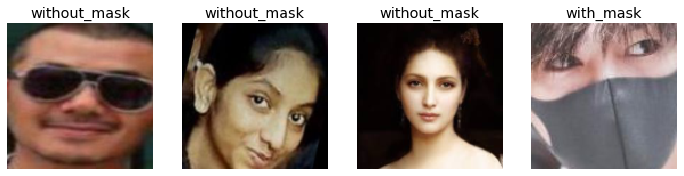

In [9]:
dls.valid.show_batch(max_n=4, nrows=1)

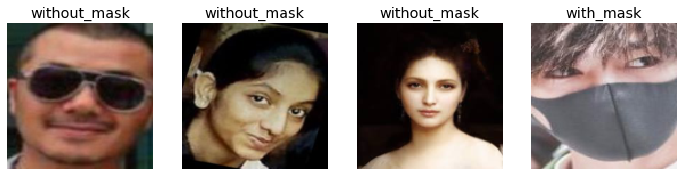

In [10]:
MUSK = MUSK.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = MUSK.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

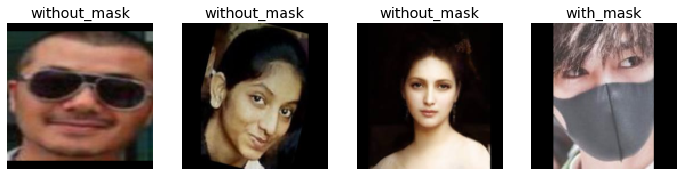

In [11]:
MUSK = MUSK.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = MUSK.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

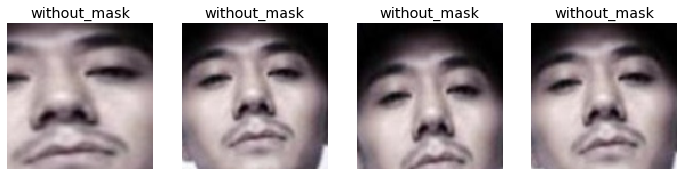

In [12]:
MUSK = MUSK.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = MUSK.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

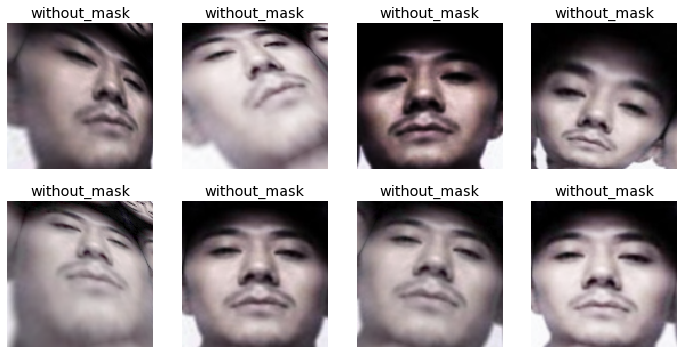

In [13]:
MUSK = MUSK.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = MUSK.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [14]:
MUSK = MUSK.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = MUSK.dataloaders(path,num_workers=0)

In [15]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.346963,0.051313,0.017157,01:08


C:\Users\kartik\anaconda3\lib\site-packages\PIL\Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,0.081801,0.008368,0.003676,01:16


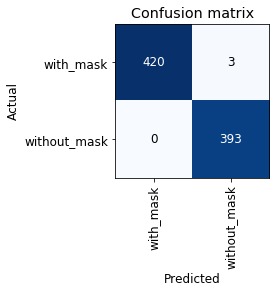

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

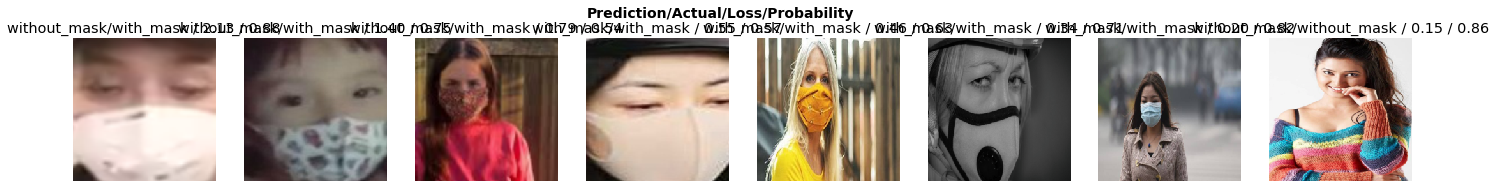

In [18]:
interp.plot_top_losses(8, nrows=1)

In [18]:
ImageClassifierCleaner??

In [20]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [19]:
for idx in cleaner.delete(): 
    print(cleaner.fns[idx])
    path = str(cleaner.fns[idx])
    os.remove(path)
    #cleaner.fns[idx].unlink()
for idx,cat in cleaner.change():
    print(str(cleaner.fns[idx]))
    path = str(cleaner.fns[idx])
    x = path.split("\\",2)
    if(x[1] == 'without_mask'):
        new_path = x[0]+'\\'+'with_mask'+"\\"+x[2]
    else:
        new_path = x[0]+'\\'+'without_mask'+'\\'+x[2]
    os.remove(path)
    print("new Path is",new_path)
    #shutil.move(str(cleaner.fns[idx]), path/cat)

NameError: name 'cleaner' is not defined

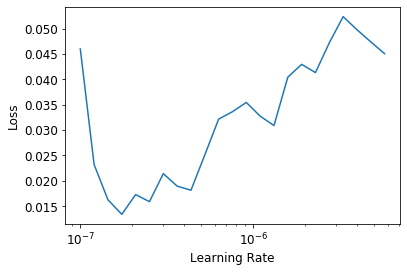

In [20]:
lr_min,lr_steep = learn.lr_find()

In [21]:
lr_min,lr_steep

(1.318256749982538e-07, 9.12010818865383e-07)

In [24]:
learn.unfreeze()
learn.fit_one_cycle(2,slice(1e-07,1.318256749982538e-07))

epoch,train_loss,valid_loss,error_rate,time
0,0.038895,0.009231,0.003676,01:13
1,0.040725,0.011268,0.004902,01:14


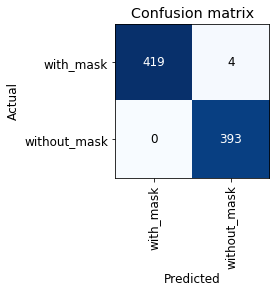

In [25]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [26]:
learn.export()

In [27]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [36]:
learn_inf = load_learner(path/'export.pkl')

In [38]:
learn_inf.dls.vocab

['with_mask', 'without_mask']

In [39]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [41]:
img = PILImage.create(btn_upload.data[-1])

In [42]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [43]:
pred,pred_idx,probs = learn_inf.predict(img)

In [44]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: with_mask; Probability: 0.9847')

In [45]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [46]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [47]:
#hide_output
VBox([widgets.Label('Select whom to check!'), 
      btn_upload, btn_run, out_pl, lbl_pred])